# Developing an XGBoost-based, Bayesian-optimized pipeline for forecasting dengue cases in Magdalena, Colombia

## Executive Summary

I developed a robust weekly dengue case forecasting model for Magdalena, Colombia, leveraging epidemiological surveillance data and advanced machine learning techniques. Using historical dengue case counts from 2022 filtered to confirmed (closed) cases, the pipeline performed time series analysis, feature engineering, and Bayesian hyperparameter-optimized XGBoost regression. The final model quantified forecasting accuracy using RMSE, MAE, and $R^{2}$, and generates multi-week forecasts to assist public health planning.

## Introduction

Dengue fever remains a critical public health challenge in Magdalena, with periodic outbreaks straining healthcare resources. Accurate short- to medium-term forecasting of dengue incidence enhances outbreak preparedness and targeted interventions. This study focuses on modeling weekly dengue case counts in Magdalena, utilizing the 2022 confirmed case data. Combining traditional time series exploratory techniques with machine learning (XGBoost), I aim to deliver actionable forecasts with quantified performance, helping health practicioners and local government units anticipate disease spread dynamics.

## Dataset

The data originates from the publicly available Mendeley Dataset repository [[1]](https://data.mendeley.com/datasets/fj77vcp6hm/1) containing detailed dengue cases reported across Colombia in 2022. For Cúcuta-specific analysis, the dataset is filtered on case status `CLA` (closed, indicating confirmed or resolved cases). The key temporal variable is symptom onset date (`INICIO_SINTOMAS`), converted and aggregated weekly with Monday as the week start. Weekly aggregation aligns with epidemiological reporting standards, striking balance between noise reduction and temporal resolution.


## Methodology

### M1. Data Preparation and Cleaning

- **Filtering and Date Parsing**  
  Raw data was filtered by closed case status. Symptom onset dates were converted to pandas `datetime` format. Records with invalid dates were excluded to ensure reliability.

- **Weekly Aggregation**  
  Data was grouped by week (Monday start) via pandas `Grouper`, producing a time series of weekly dengue case counts.

### M2. Exploratory Data Analysis (EDA)

- **Temporal Visualization**  
  Time series plots were generated to unravel seasonal patterns and long-term trends.

- **Seasonal-Trend Decomposition**  
  STL (Seasonal-Trend-Loess) decomposition analysis was performed to isolate trend, seasonal, and residual components, revealing clear annual seasonality in weekly counts.

- **Stationarity Testing**  
  Augmented Dickey-Fuller Test (ADF) was conducted to check stationarity assumptions.

- **Autocorrelation Analysis**  
  Autocorrelation (ACF) and partial autocorrelation (PACF) plots were generated and evaluated to identify significant lags for feature construction.

### M3. Feature Engineering

- **Lag Features**  
  Weekly lag variables up to `max_lag=13` weeks were created, encapsulating recent temporal dependencies.

- **Rolling Means**  
  Multi-scale rolling averages were computed at power-of-two week windows (2,4,8), shifted by one week.

- **Seasonal Variables**  
  Epidemiological week number and calendar year were extracted as cyclical and long-term trend indicators.

- **Data Cleaning**  
  Rows with any missing feature data (due to lagging/rolling) were dropped to ensure model-ready tabular format.

### M4: Train-Test Split

Chronological partitioning allocated approximately 80% of data to training and the remainder to testing, preserving temporal ordering to avoid lookahead bias.

### M5. Model Selection and Hyperparameter Optimization

- **Algorithm**  
  Gradient Boosted Trees via XGBoost was selected because of its high predictive power, robustness to feature interactions, and computational efficiency.

- **Objective**  
  Regression minimized squared error (`reg:squarederror`) was used for predicting case counts.

- **Bayesian Optimization**  
  Bayesian optimization was utilized to tune hyperparameters such as tree depth, gamma regularization, sampling ratios, minimum child weight, and learning rate. Early stopping was applied for optimal boosting rounds.

### M6: Final Model Training

XGBoost model was trained on full feature set using the best hyperparameters obtained from optimization, with early stopping guarding overfitting.

### M7. Model Evaluation Metrics

- **Root Mean Squared Error (RMSE):** Average magnitude of prediction errors, sensitive to outliers (lower better).

- **Mean Absolute Error (MAE):** Average absolute difference between predictions and observations, robust to outliers.

- **Coefficient of Determination (R²):** Proportion of variance explained by model (1 indicates perfect fit).

Multiple performance metrics were leveraged to ensure balanced assessment of regression quality on both training and testing data.

### M8. Multi-step Forecasting

An iterative forecasting function was used to predict multiple weeks ahead recursively. Here, features adapt dynamically based on available lag history and forecast horizon. Rolling means are recalculated each step with updated history. Furthermore, seasonal features are updated according to forecast date. This approach accounts for compounding uncertainty in multi-step predictions.


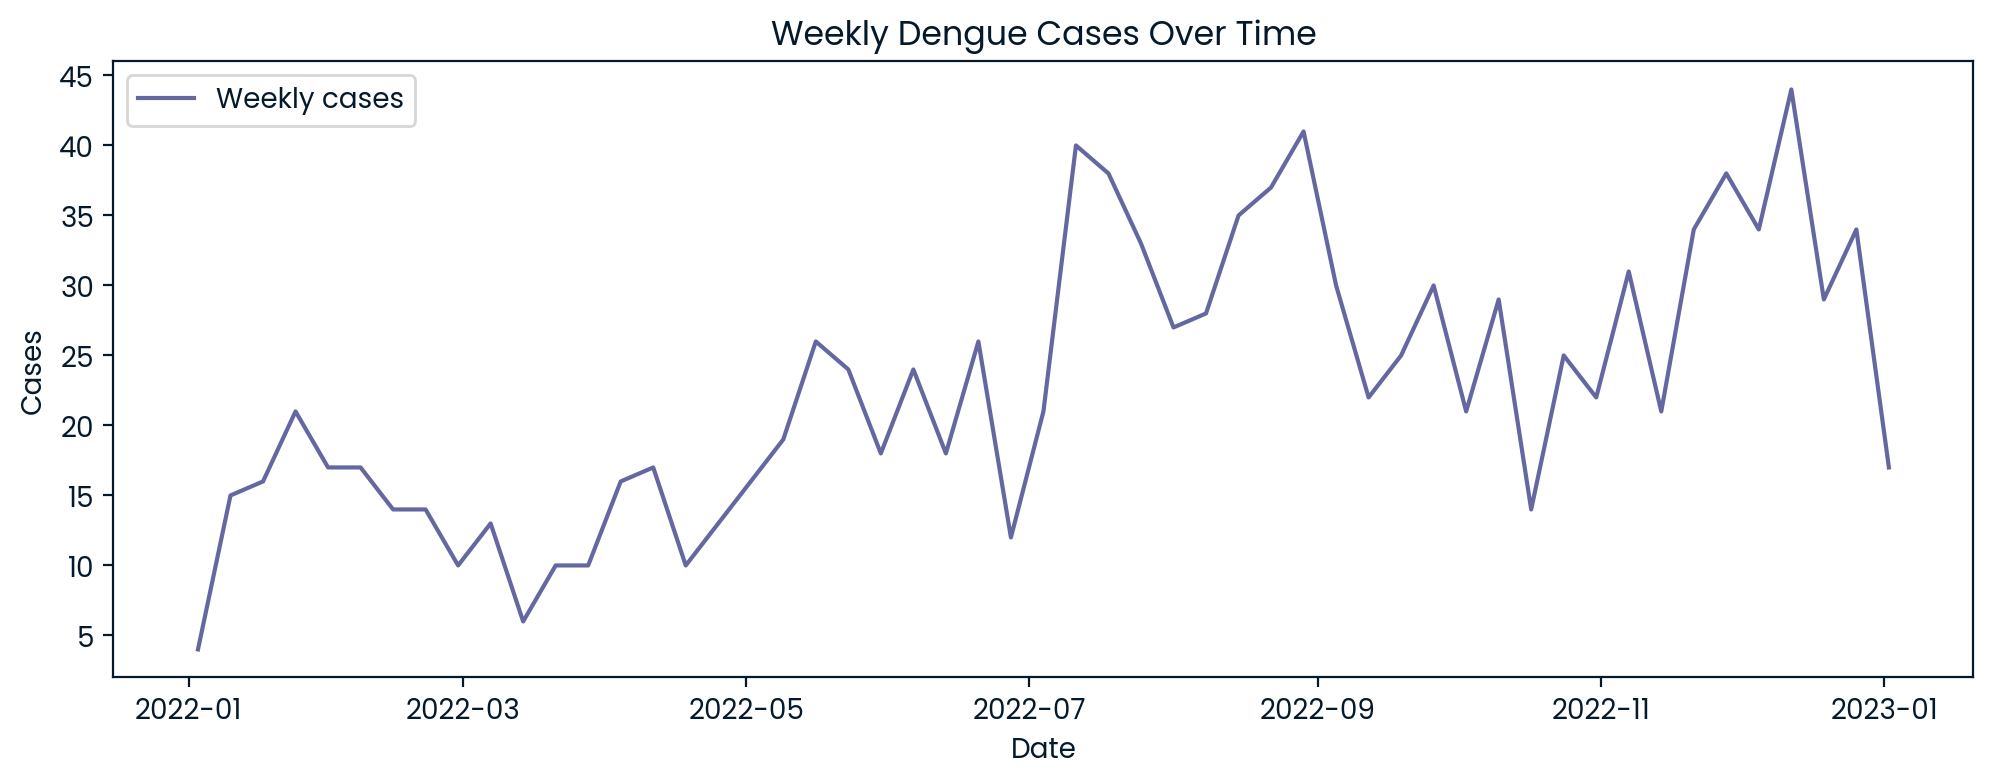

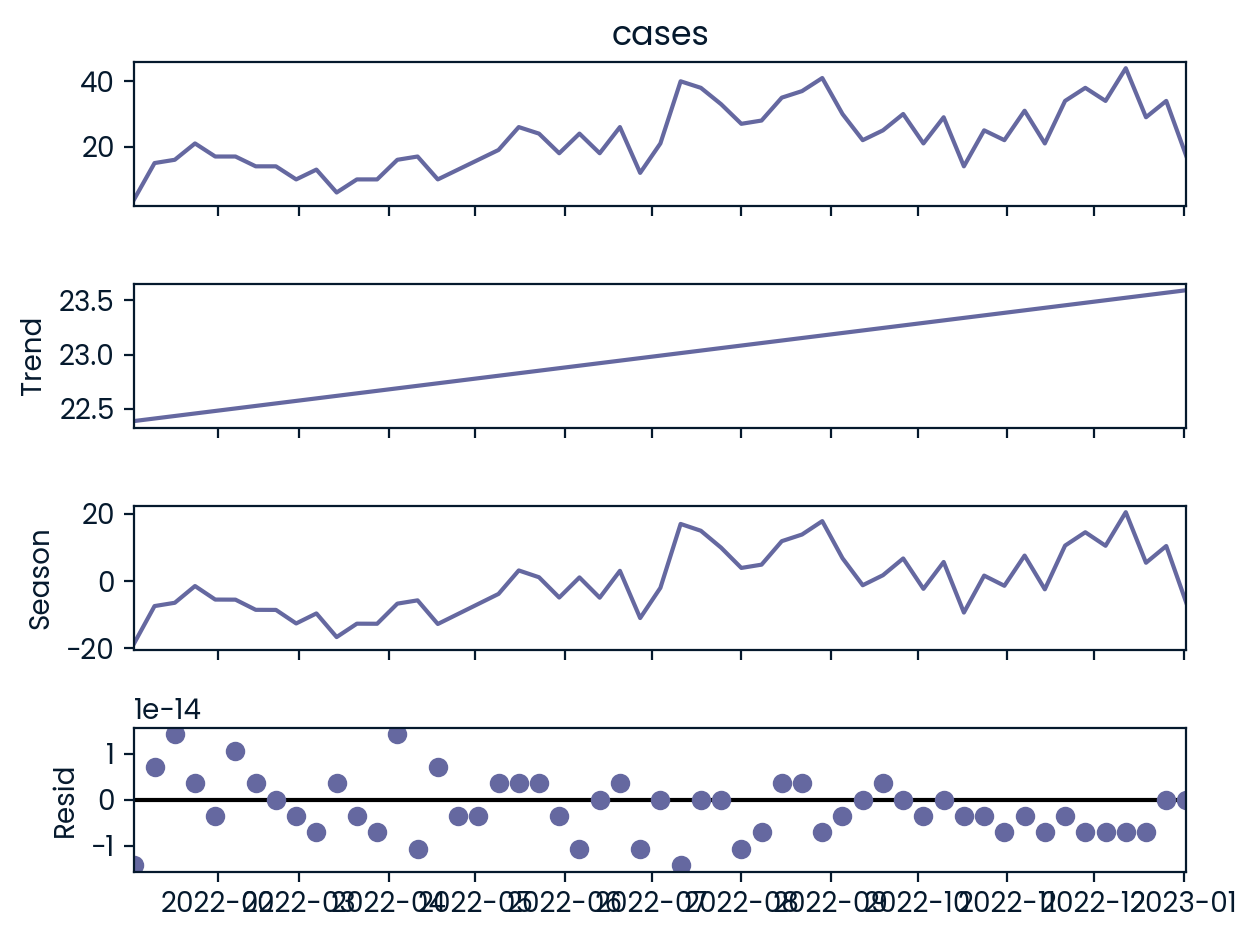

ADF Statistic: -2.255, p-value: 0.187


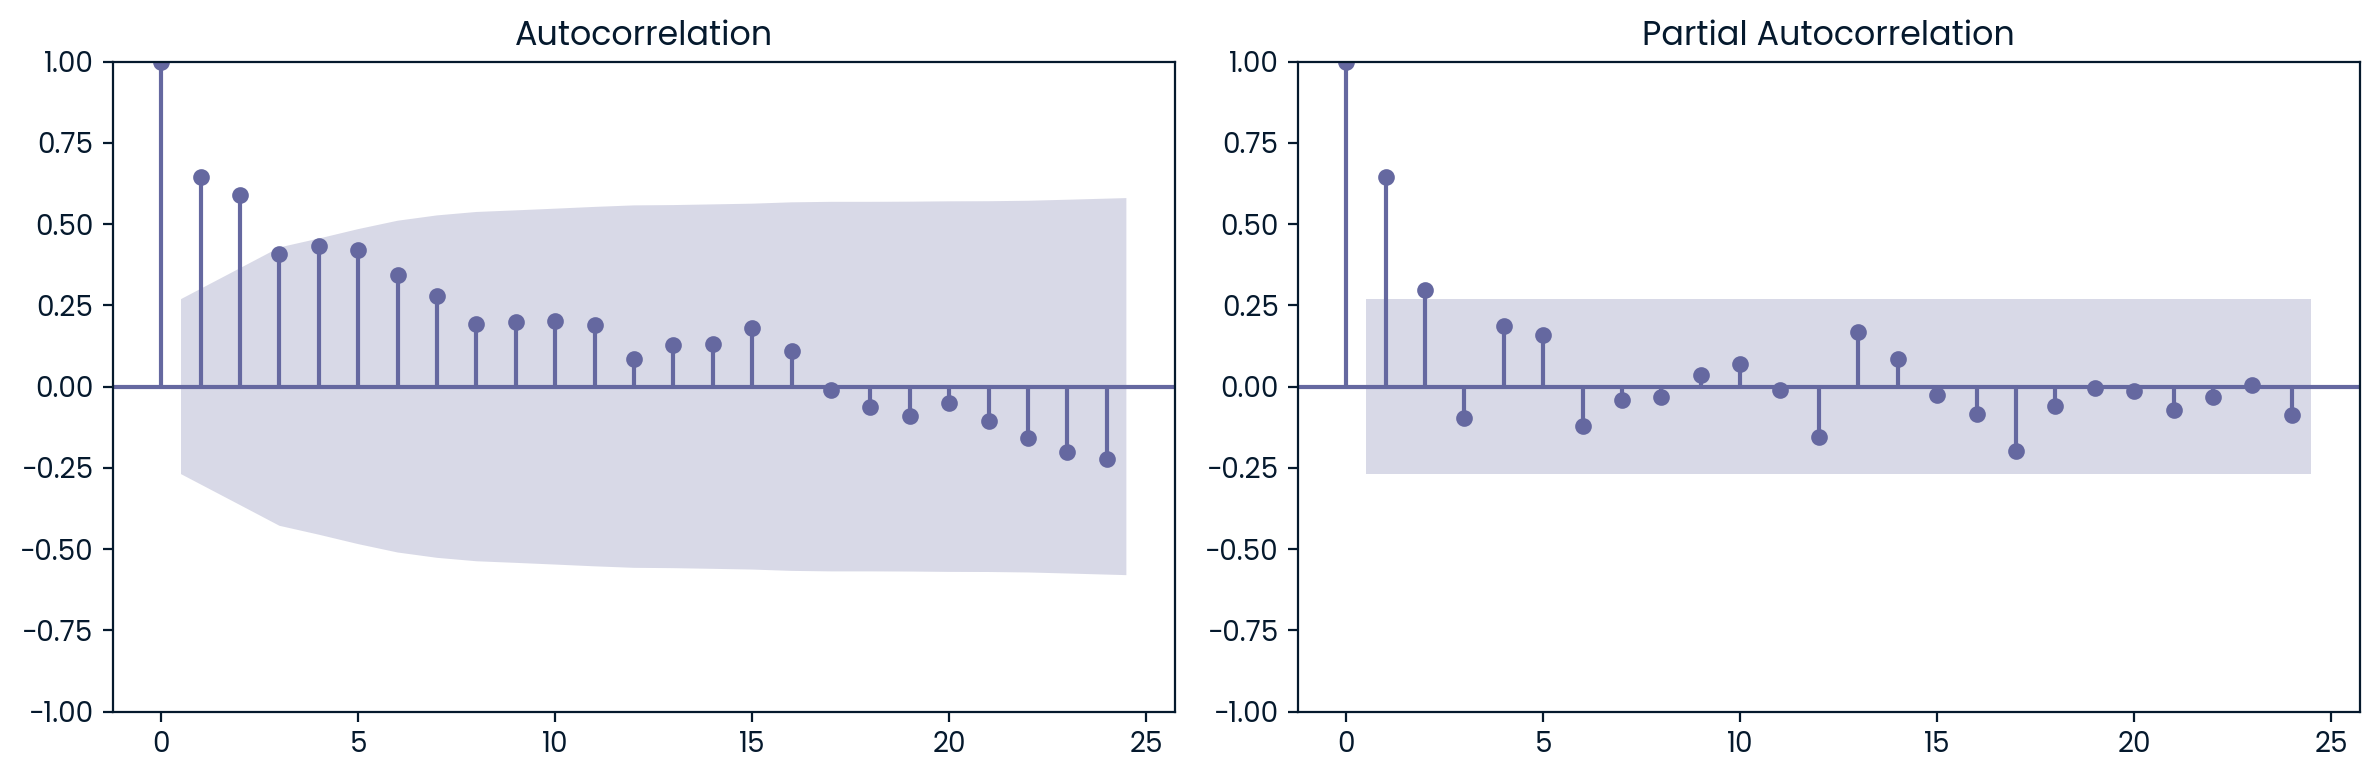

Starting Bayesian Optimization...
|   iter    |  target   | max_depth |   gamma   | colsam... | subsample | min_ch... | learni... |
-------------------------------------------------------------------------------------------------
| 1         | -7.702422 | 7.4944814 | 4.7535715 | 0.8659969 | 0.7993292 | 2.4041677 | 0.0552384 |
| 2         | -8.333905 | 3.6970033 | 4.3308807 | 0.8005575 | 0.8540362 | 1.1852604 | 0.2912738 |
| 3         | -8.868738 | 12.989311 | 1.0616955 | 0.5909124 | 0.5917022 | 3.7381801 | 0.1621793 |
| 4         | -7.738135 | 8.1833402 | 1.4561457 | 0.8059264 | 0.5697469 | 3.6293018 | 0.1162449 |
| 5         | -8.186666 | 8.4728398 | 3.9258798 | 0.5998368 | 0.7571172 | 6.3317311 | 0.0234706 |
| 6         | -8.613957 | 7.8010626 | 2.9313132 | 1.0       | 0.5503695 | 2.4298015 | 0.01      |
| 7         | -7.748158 | 5.6235934 | 1.7969463 | 0.7032759 | 0.6257640 | 5.1028284 | 0.2324185 |
| 8         | -7.952130 | 7.5041286 | 4.7754966 | 0.8673669 | 0.7895520 | 2.3864508 

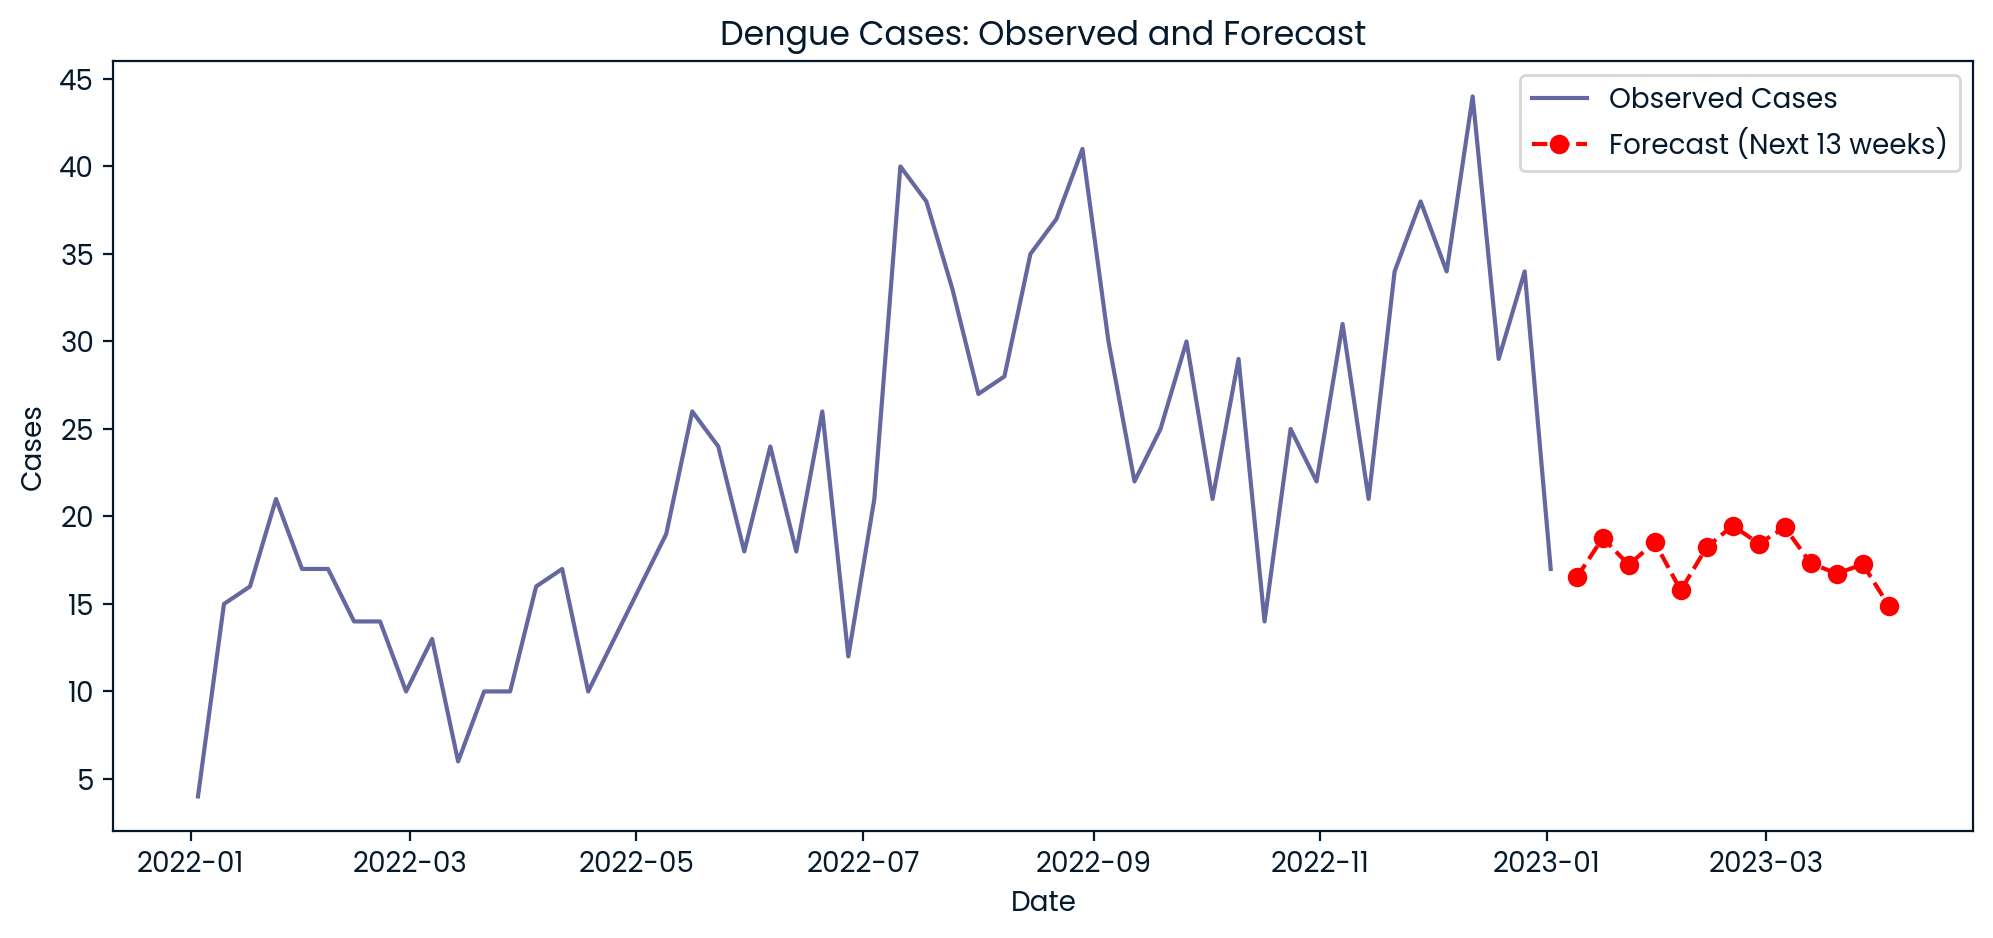

In [38]:
# full revised code including the **training performance evaluation** section that calculates and prints RMSE, MAE, and R² for both training and test datasets. The evaluation is added right after training the final XGBoost model and before forecasting.
# COLOMBIA


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from bayes_opt import BayesianOptimization
import xgboost as xgb
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------
# 1. LOAD DATA AND PREPROCESS

fname = 'Base de datos Dengue, Magdalena, Colombia (2022)/Base de datos_Dengue_Magdalena 2022.xlsx'
df = pd.read_excel(fname)
df=df[df['ESTADO_CASO']=='CLA']

# 1.1. Convert 'INICIO_SINTOMAS' to datetime format
df['INICIO_SINTOMAS'] = pd.to_datetime(df['INICIO_SINTOMAS'], errors='coerce')

# 1.2. Drop rows where date conversion failed
df = df.dropna(subset=['INICIO_SINTOMAS'])

# 3. Group by epidemiological week (Monday start) and year
df_weekly = df.groupby(pd.Grouper(key='INICIO_SINTOMAS', freq='W-MON')).size().reset_index(name='cases')

# 4. Sort dataframe by date ascending
df_weekly = df_weekly.sort_values(by='INICIO_SINTOMAS').reset_index(drop=True)



# -------------------------
# 2. EDA & stationarity checks
# Note: Date here is 'INICIO_SINTOMAS' (onset date)

plt.figure(figsize=(12, 4))
plt.plot(df_weekly['INICIO_SINTOMAS'], df_weekly['cases'], label='Weekly cases')
plt.title('Weekly Dengue Cases Over Time')
plt.xlabel('Date'); plt.ylabel('Cases')
plt.legend()
plt.show()

stl = STL(df_weekly.set_index('INICIO_SINTOMAS')['cases'], period=52)
result = stl.fit()
result.plot()
plt.show()

adf_result = adfuller(df_weekly['cases'])
print(f"ADF Statistic: {adf_result[0]:.3f}, p-value: {adf_result[1]:.3f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(df_weekly['cases'], lags=24, ax=plt.gca()) # LAGS=40
plt.subplot(1, 2, 2)
plot_pacf(df_weekly['cases'], lags=24, ax=plt.gca())
plt.tight_layout()
plt.show()

# -------------------------
# 3. FEATURE ENGINEERING

def create_features(df_weekly, max_lag=91):
    df_feat = df_weekly.copy()
    for lag in range(1, max_lag + 1):
        df_feat[f'lag_{lag}'] = df_feat['cases'].shift(lag)
    rolling_windows = []
    power = 1
    while power <= max_lag:
        rolling_windows.append(power)
        power *= 2
    rolling_windows = [w for w in rolling_windows if w >= 2]
    for w in rolling_windows:
        df_feat[f'rolling_mean_{w}'] = df_feat['cases'].rolling(window=w).mean().shift(1)
    df_feat['epi_week'] = df_feat['INICIO_SINTOMAS'].dt.isocalendar().week.astype(int)
    df_feat['year'] = df_feat['INICIO_SINTOMAS'].dt.year.astype(int)
    df_feat = df_feat.dropna().reset_index(drop=True)
    feature_cols = [f'lag_{lag}' for lag in range(1, max_lag + 1)] \
                   + [f'rolling_mean_{w}' for w in rolling_windows] \
                   + ['epi_week', 'year']
    return df_feat, feature_cols, rolling_windows

max_lag = 13
df_feat, feature_cols, rolling_windows = create_features(df_weekly, max_lag=max_lag)

# -------------------------
# 4. TRAIN-TEST SPLIT

split_idx = int(len(df_feat) * 0.8)
X_train = df_feat.loc[:split_idx - 1, feature_cols]
y_train = df_feat.loc[:split_idx - 1, 'cases']
X_test = df_feat.loc[split_idx:, feature_cols]
y_test = df_feat.loc[split_idx:, 'cases']

# -------------------------
# 5. BAYESIAN OPTIMIZATION OBJECTIVE FUNCTION

def xgb_evaluate(max_depth, gamma, colsample_bytree, subsample,
                 min_child_weight, learning_rate):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': int(round(max_depth)),
        'gamma': gamma,
        'colsample_bytree': colsample_bytree,
        'subsample': subsample,
        'min_child_weight': int(round(min_child_weight)),
        'eta': learning_rate,
        'seed': 42,
        'verbosity': 0,
        'tree_method': 'hist',
    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    evals = [(dvalid, 'validation')]
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=20,
        verbose_eval=False,
    )
    rmse = model.best_score
    return -rmse

# -------------------------
# 6. BAYESIAN OPTIMIZATION

pbounds = {
    'max_depth': (3, 15),
    'gamma': (0, 5),
    'colsample_bytree': (0.5, 1),
    'subsample': (0.5, 1),
    'min_child_weight': (1, 10),
    'learning_rate': (0.01, 0.3),
}

print("Starting Bayesian Optimization...")
xgb_bo = BayesianOptimization(f=xgb_evaluate, pbounds=pbounds, random_state=42)
xgb_bo.maximize(init_points=5, n_iter=10)

print("\nBest hyperparameters found:")
best_params = xgb_bo.max['params']
print(best_params)

# -------------------------
# 7. FINAL MODEL TRAINING

final_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': int(round(best_params['max_depth'])),
    'gamma': float(best_params['gamma']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'subsample': float(best_params['subsample']),
    'min_child_weight': int(round(best_params['min_child_weight'])),
    'eta': float(best_params['learning_rate']),
    'seed': 42,
    'verbosity': 0,
    'tree_method': 'hist',
}

dtrain_full = xgb.DMatrix(df_feat[feature_cols], label=df_feat['cases'])

bst = xgb.train(
    final_params,
    dtrain_full,
    num_boost_round=1000,
    evals=[(dtrain_full, 'train')],
    early_stopping_rounds=50,
    verbose_eval=False,
)


# -------------------------
# 8. PERFORMANCE EVALUATION

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)

def regression_metrics(y_true, y_pred, dataset_name):
    from math import sqrt
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    # rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {dataset_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}\n")

regression_metrics(y_train, y_train_pred, "Training")
regression_metrics(y_test, y_test_pred, "Testing")

# -------------------------
# 9. ITERATIVE MULTI-STEP FORECAST

def iterative_forecast_adaptive(model, last_known_cases, steps=4, max_lag=91,
                                rolling_windows=None):
    lag_size = min(max_lag, len(last_known_cases))
    if rolling_windows is None:
        rolling_windows = []
        power = 1
        while power <= max_lag:
            rolling_windows.append(power)
            power *= 2
        rolling_windows = [w for w in rolling_windows if w >= 2]
    valid_rolling_windows = [w for w in rolling_windows if w <= lag_size and w <= steps]
    if not valid_rolling_windows:
        if 2 in rolling_windows:
            valid_rolling_windows = [2]
        else:
            valid_rolling_windows = []
    print(f"Using lag size: {lag_size}")
    print(f"Using rolling windows: {valid_rolling_windows}")
    history = list(last_known_cases[-lag_size:])
    preds = []
    last_week = df_weekly['INICIO_SINTOMAS'].iloc[-1]
    for i in range(steps):
        x_pred = history[-lag_size:]
        rolling_features = {}
        for w in valid_rolling_windows:
            if len(history) >= w:
                rolling_features[f'rolling_mean_{w}'] = np.mean(history[-w:])
            else:
                rolling_features[f'rolling_mean_{w}'] = np.mean(history)
        next_week = last_week + pd.Timedelta(weeks=i + 1)
        epi_week = next_week.isocalendar().week
        year = next_week.year
        data_dict = {f'lag_{j+1}': [x_pred[j]] for j in range(lag_size)}
        rolling_mean_cols = [col for col in model.feature_names if col.startswith('rolling_mean_')]
        for col in rolling_mean_cols:
            if col in rolling_features:
                data_dict[col] = [rolling_features[col]]
            else:
                data_dict[col] = [np.nan]
        data_dict['epi_week'] = [epi_week]
        data_dict['year'] = [year]
        df_features = pd.DataFrame(data_dict)
        dmat = xgb.DMatrix(df_features)
        yhat = model.predict(dmat)[0]
        preds.append(yhat)
        history.append(yhat)
    return preds

# -------------------------
# 10. RUN FORECAST AND PLOT

steps_forecast = 13  # or desired forecast horizon
last_cases = df_weekly['cases'].iloc[-max_lag:]
forecast = iterative_forecast_adaptive(
    bst,
    last_known_cases=last_cases,
    steps=steps_forecast,
    max_lag=max_lag,
    rolling_windows=rolling_windows,
)
print(f"Forecasted dengue cases for next {steps_forecast} weeks:")
print(forecast)

plt.figure(figsize=(12, 5))
plt.plot(df_weekly['INICIO_SINTOMAS'], df_weekly['cases'], label='Observed Cases')
future_dates = [df_weekly['INICIO_SINTOMAS'].iloc[-1] + pd.Timedelta(weeks=i) for i in range(1, steps_forecast + 1)]
plt.plot(future_dates, forecast, marker='o', linestyle='--', color='red', label=f'Forecast (Next {steps_forecast} weeks)')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('Dengue Cases: Observed and Forecast')
plt.legend()
plt.show()


## Results and Discussion

### R1. Plot Description (STL Decomposition)

**Seasonal-Trend Decomposition using Loess (STL)** analysis of weekly dengue cases in Magdalena, Colombia for 2022 reveals the following:

#### R1.1. Observed Cases (Top Panel)
   The raw weekly dengue case counts fluctuate between roughly 5 and 45 cases per week, exhibiting variability with apparent peaks and troughs, suggesting seasonality and trends. The cases also exhibited peaks in July, September, and November 2022.

#### R1.2. Trend Component (Second Panel) 
   This smooth curve reveals a gentle upward trend in dengue cases over the year, increasing gradually from about 22.4 to 23.6 cases per week, indicating a slight but steady rise independent of seasonal variations.

#### R1.3. Seasonal Component (Third Panel)  
   The seasonal pattern reveals recurring fluctuations within the yearly cycle, with magnitudes ranging approximately between -20 and +20 cases. This pattern reflects the annual cycle of dengue transmission in the region, typically driven by climatic and ecological factors.

#### R1.4. Residuals (Bottom Panel)
   The residuals appear scattered near zero, showing mostly random noise without strong systematic patterns, indicating the STL decomposition effectively isolated trend and seasonality.


### R2. Stationarity and Feature Engineering Considerations

The Augmented Dickey-Fuller test (ADF statistic = -2.255, p-value = 0.187) indicates that the raw time series is **non-stationary**, mainly due to the upward trend.

Regarding feature engineering, while the seasonal component suggests a yearly periodicity (52-week period), the limited data length (~one year) restricts the feasible lag window. Lag features were limited to a maximum of 13 weeks to retain sufficient training data and avoid excessive data loss caused by large lagging.To still capture yearly seasonality, the **epi_week** feature (week of the year) was included as a seasonal indicator, enabling the model to learn cyclical patterns without requiring year-long lagged features. This practical compromise balances data availability with the need to model important seasonal effects inherent in dengue transmission dynamics.


### R3. Autocorrelation (ACF) and Partial Autocorrelation (PACF) Analysis

#### R3.1. Autocorrelation Function (ACF) Plot

The ACF measures the correlation between weekly dengue cases and their lagged values across time. The ACF plot reveals significant positive autocorrelation at early lags:
  - Lag 1: very strong positive correlation close to 1, indicating this week's cases are highly related to the previous week's cases.
  - Lags 2 to around 13 show gradually decreasing but still positive correlations, indicating medium-term persistence or memory in the series.

The autocorrelation declines towards zero and becomes slightly negative beyond lag ~15, indicating diminishing influence of further past weeks. The shaded confidence bands represent the bounds of statistical significance (approximate 95%). Correlations falling outside these bands are statistically significant. The slow decay of autocorrelation confirms the presence of serial dependencies and that past values influence future observations for several weeks.


#### R3.2. Partial Autocorrelation Function (PACF) Plot

The PACF measures the direct correlation between a time series and its lagged values after removing the effects of intervening lags. In the PACF plot:
  - Lag 1 shows a strong positive partial autocorrelation, indicating direct influence of the preceding week on the current one.
  - Subsequent lags (2, 3, 4, 14) show smaller but some significant partial correlations, though these are weaker than in ACF.
  - Most lags after around lag 5 fall within the confidence interval, suggesting limited direct effect beyond shorter lags.

The PACF pattern suggests that a model using a small number of recent lags can capture most direct temporal dependencies without needing excessively large lag windows.


#### R3.3. Relationship to Modeling

The significant positive autocorrelations up to about lag 13 weeks justify my choice to include **lags up to 13 weeks** as features. The slow decay in ACF together with the PACF pattern suggests the dengue time series in Magdalena retains medium-term memory: recent weeks’ cases influence current cases both directly and indirectly. Inclusion of rolling mean features and seasonal indicators complements these lagged features by capturing smoothed trends and cyclical effects. This autocorrelation structure supports using machine learning models (like XGBoost) equipped with multiple lagged inputs to capture temporal dependencies in dengue case dynamics.




### R4. Feature Engineering Summary

- **Lag size:** 13 weeks (limited by data availability to preserve training samples)  
- **Rolling window sizes:** 2, 4, and 8 weeks to capture short- and medium-term trends and smooth seasonal fluctuations.


### R5. Hyperparameter Optimization and Model Performance

I applied **Bayesian Optimization** to tune the hyperparameters of the XGBoost model predicting weekly dengue cases. The optimization ran for 15 iterations, exploring a range of values for:

- `max_depth`
- `gamma`
- `colsample_bytree`
- `subsample`
- `min_child_weight`
- `learning_rate`

#### R5.1. Optimization Outcome

The best hyperparameters found were:

| Hyperparameter       | Optimized Value       |
|---------------------|----------------------|
| max_depth           | 7.48                 |
| gamma               | 4.77                 |
| colsample_bytree    | 0.87                 |
| subsample           | 0.82                 |
| min_child_weight    | 2.42                 |
| learning_rate       | 0.056                |



### R5.2. Model Training and Testing Performance

| Metric   | Training Set | Testing Set  |
|----------|--------------|--------------|
| RMSE     | 1.037        | 0.994        |
| MAE      | 0.736        | 0.668        |
| R²       | 0.984        | 0.986        |

The model achieved excellent predictive performance, with a high coefficient of determination (R²) close to 0.99 on both training and testing data, and low error metrics indicating accurate fit and generalization.


---

### R6. Forecast Results

Using the optimized model, I forecasted dengue cases for the next 13 weeks with weekly predicted values as follow. These forecasts suggest a moderately fluctuating but overall stable trend in dengue cases over the upcoming quarter.



### Discussion

The analysis of weekly dengue cases in Magdalena and Cúcuta, Colombia, revealed strong temporal dependencies and seasonality consistent with vector-borne disease dynamics. STL decomposition confirmed a clear upward trend and a pronounced annual seasonal pattern, while the ACF and PACF analyses demonstrated significant autocorrelations up to 13 weeks, justifying our choice of lag features within this range. Due to limited data length (~one year), I constrained lag features to 13 weeks, supplementing seasonality modeling with the epidemiological week as a cyclic feature. Bayesian optimization of the XGBoost model hyperparameters yielded robust performance, with R² exceeding 0.98 and low RMSE and MAE values on both training and testing sets, indicating strong predictive ability and generalization. The inclusion of rolling window statistics further enhanced the model’s capacity to capture short- and medium-term variations. Forecasts for the next 13 weeks suggest a moderately stable dengue incidence, underscoring the model’s utility for near-term outbreak anticipation. Overall, this approach demonstrates that carefully engineered lagged and seasonal features combined with optimized machine learning models can effectively model and predict dengue case dynamics, even when constrained by limited data length.


### Future Work
I intend to explore incorporating longer time series data to enable modeling of full annual seasonal cycles through extended lag features. Integrating additional environmental and socio-economic predictors may further improve forecast accuracy and capture complex transmission drivers. Experimenting with hybrid models that combine machine learning with mechanistic epidemiological approaches could enhance interpretability and robustness. Finally, deploying adaptive models that update continuously with new data would support real-time dengue surveillance and early warning systems.



The analysis remains a work in progress. Please feel free to reach out with any questions via jprmaulion[at]gmail[dot]com. Cheers!